In [1]:
from src.utils.training import get_objective, get_optimizer
from src.utils.data import load_dataset
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
 
from src.optim.SOREL import Sorel
from src.optim.SOREL_batch import SorelBatch

# Load Dataset

In [2]:
dataset = "yacht" # ["yacht", "concrete", "energy", "kin8nm", "power"]

X_train, y_train, X_test, y_test = load_dataset(dataset)

# Get Objective and Optimizer

In [3]:
# Build objective.
model_cfg = {
    "objective": "cvar", # Options: 'cvar', 'extremile', 'esrm'. 
    "para_value": 0.5,   # to apply alpha-cvar, rho-esrm or r-extremile,  set para_value = 1-alpha (cvar) or rho (esrm) or r (extremile).
    "l2_reg": 1.0,
    "loss": "squared_error",  # Options: 'squared_error', 'binary_cross_entropy', 'multinomial_cross_entropy'.
    "n_class": None,
    "shift_cost": 0,
}
autodiff = False # non-autodiff variants
train_obj = get_objective(model_cfg, X_train, y_train, autodiff=autodiff)
val_obj   = get_objective(model_cfg, X_test, y_test, autodiff=autodiff)

In [4]:
lr = 0.03
lrd = 0.2
seed = 1
optimizer = Sorel(
                train_obj,
                lr=lr,
                smooth_coef=0,
                smoothing="l2",
                seed=seed,
                length_epoch=train_obj.n,
                lrdcon=lrd,
)

In [5]:
# You can get baseline optimizers by running the following code.
# optim_cfg = {
#         "optimizer": "sgd", # Options: 'sgd', 'lsvrg', 'prospect'
#         "lr": lr,
#         "epoch_len": train_obj.n, # Used as an update interval for LSVRG, and otherwise is simply a logging interval for other methods.
#         "shift_cost": 0,
#     }

# optimizer = get_optimizer(optim_cfg, train_obj, seed)

# Training

In [6]:
# Get the optimal solution by L-BFGS
train_obj_ = get_objective(model_cfg, X_train, y_train)

# Define function and Jacobian oracles.
def fun(w):
    return train_obj_.get_batch_loss(torch.tensor(w, dtype=torch.float64)).item()

def jac(w):
    return (
        train_obj_.get_batch_subgrad(
            torch.tensor(w, dtype=torch.float64, requires_grad=True)
        )
        .detach()
        .numpy()
    )

# Run optimizer.
d = train_obj.d
init = np.zeros((d,), dtype=np.float64)
if model_cfg["n_class"]:
    init = np.zeros((model_cfg["n_class"] * d,), dtype=np.float64)
else:
    init = np.zeros((d,), dtype=np.float64)
output = minimize(fun, init, method="L-BFGS-B", jac=jac)
if output.success:
    print(f"L-BGFS sucsess! Minimum loss on {dataset}: {output.fun:0.4f}")
else:
    raise Exception(output.message)

L-BGFS sucsess! Minimum loss on yacht: 0.2959


In [7]:
n_epochs = 100

train_losses = []
epoch_len = optimizer.get_epoch_len()
for epoch in tqdm(range(n_epochs)):

    optimizer.start_epoch()
    for _ in range(epoch_len):
        optimizer.step()
    optimizer.end_epoch()
    train_losses.append(train_obj.get_batch_loss(optimizer.weights).item())

100%|██████████| 100/100 [00:01<00:00, 62.15it/s]


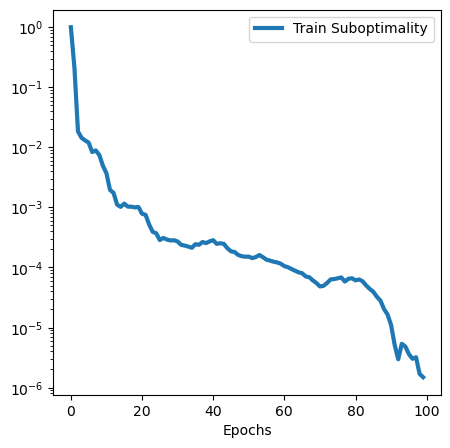

In [8]:
# Display training suboptimality.

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

t = np.arange(len(train_losses))

minimum_loss = output.fun
train_losses = np.array(train_losses)
subopt = (train_losses - minimum_loss) / (train_losses[0] - minimum_loss)

ax.plot(np.arange(len(subopt)), subopt, linewidth=3, label=r"Train Suboptimality")
ax.set_xlabel("Epochs")

ax.legend()
ax.set_yscale("log")
plt.show()